<a href="https://colab.research.google.com/github/PsorTheDoctor/microarray-data/blob/main/notebooks/microarray_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vanilla GAN: Generowanie mikromacierzy
##Import bibliotek

In [1]:
!git clone https://github.com/PsorTheDoctor/microarray-data.git
%cd microarray-data/

Cloning into 'microarray-data'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 159 (delta 51), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (159/159), 3.47 MiB | 4.38 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/microarray-data


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from utils.load_data import load_data_by_label
from utils.augmentation import *

##Przygotowanie danych

In [3]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 512

latent_dim = 128

(X_train, X_test) = load_data_by_label(label=1)
X = np.concatenate((X_train, X_test))

print(f'Number of examples: {len(X)}')
print(f'Shape of the images in the dataset: {X.shape[1:]}')

X = X.reshape(X.shape[0], *IMG_SHAPE).astype('float32')
# Konwersja do obrazów binarnych
# X = np.where(X < 0.5, 0, 1).astype('float32')

Number of examples: 471
Shape of the images in the dataset: (32, 32)


##Budowa dyskryminatora

In [41]:
def build_discriminator():
  img_input = layers.Input(shape=IMG_SHAPE)
  x = layers.Flatten(input_shape=IMG_SHAPE)(img_input)

  # Warstwa wejściowa
  x = layers.Dense(512)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  # Warstwa ukryta
  x = layers.Dense(256)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  # Warstwa wyjściowa
  x = layers.Dense(1, activation='sigmoid')(x)

  discriminator = keras.models.Model(img_input, x, name='discriminator')
  return discriminator

discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

#Budowa generatora

In [42]:
def build_generator():
  noise = layers.Input(shape=(latent_dim,))

  # Warstwa wejściowa
  x = layers.Dense(256)(noise)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)

  # Warstwa ukryta
  x = layers.Dense(512)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)

  # Warstwa wyjściowa
  x = layers.Dense(1024)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.Reshape((32, 32, 1))(x)

  generator = keras.models.Model(noise, x, name='generator')
  return generator

generator = build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_39 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               20

##Nadpisanie kroku treningowego

In [22]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

##Trening modelu

In [35]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
history = gan.fit(X, batch_size=BATCH_SIZE, epochs=100, verbose=2)

Text(0, 0.5, 'Strata')

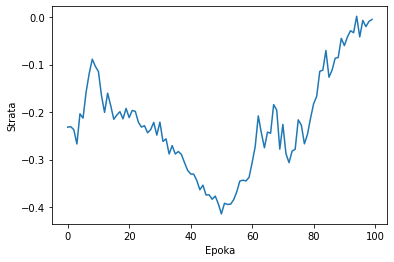

In [57]:
plt.plot(history.history['d_loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

Text(0, 0.5, 'Strata')

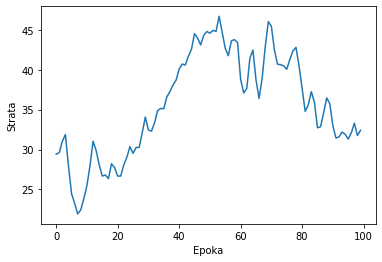

In [58]:
plt.plot(history.history['g_loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

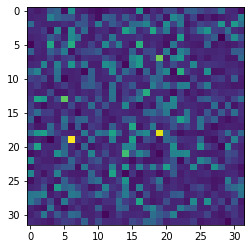

In [59]:
num_img = 1
latent_dim = 128

random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
generated_images = generator(random_latent_vectors)
# generated_images = (generated_images * 127.5) + 127.5

# for i in range(num_img):
#   img = generated_images[i].numpy()
#   img = keras.preprocessing.image.array_to_img(img)

res = np.array(generated_images[0]).reshape((32, 32))

plt.imshow(res, cmap='viridis')

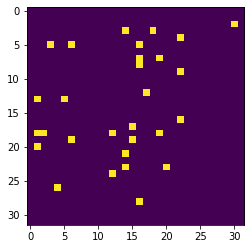

In [61]:
res = np.where(res < 0.8, 0, 1)
plt.imshow(res, cmap='viridis')